In [1]:
ENV_DIR = r'C:\Data_drive\Virtual_Env'
LOCAL_GIT_PATH = R'C:\Data_drive\Github'
ENV_NAME = 'CLIP'

# Create the Virtual Environment

In [2]:
change_dir = 'cd ' + ENV_DIR

#create the virtual environment
create = 'python -m venv --system-site-packages ' + ENV_NAME

#activate the virtual environment
activate = '.\\' + ENV_NAME + r'\Scripts\activate'

#install to properly sync with Jupyter
upgrade = 'python -m pip install --upgrade pip'
upgrade2 = 'pip install --upgrade pywin32==225'

#sync with jupyter
install = 'pip install ipykernel'
install2 = 'python -m ipykernel install --user --name=' + ENV_NAME

#install required packages
install3 = 'pip install --ignore-installed --upgrade tensorflow==2.5.0'
install4 = 'pip install -q -U tensorflow-hub tensorflow-text tensorflow-addons'


!{change_dir} && {create} && {activate} && {upgrade} && {upgrade2} && {install} && {install2} && {install3} && {install4}

  Using cached pip-21.1.2-py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.2.3
    Uninstalling pip-20.2.3:
      Successfully uninstalled pip-20.2.3
  Using cached pywin32-225-cp38-cp38-win_amd64.whl (9.1 MB)
  Attempting uninstall: pywin32
    Found existing installation: pywin32 227
    Not uninstalling pywin32 at c:\users\blain\anaconda3\lib\site-packages, outside environment c:\data_drive\virtual_env\clip
    Can't uninstall 'pywin32'. No files were found to uninstall.
Installed kernelspec CLIP in C:\Users\blain\AppData\Roaming\jupyter\kernels\clip
  Using cached tensorflow-2.5.0-cp38-cp38-win_amd64.whl (422.6 MB)
  Using cached grpcio-1.34.1-cp38-cp38-win_amd64.whl (2.9 MB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Using cached keras_nightly-2.5.0.dev2021032900-py2.py3-none-any.whl (1.2 MB)
  Using cached typing_extensions-3.7.4.3-py3-none-any.whl (22 kB)
  Using cached absl_py-0.13.0-py3-none-any.whl (132 kB)
  Us

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.
lvis 0.5.3 requires opencv-python>=4.1.0.25, which is not installed.
tensorflow-model-optimization 0.5.1.dev0 requires dm-tree~=0.1.1, which is not installed.
tensorflow-datasets 4.3.0 requires importlib-resources, which is not installed.
tensorflow-datasets 4.3.0 requires promise, which is not installed.
tensorflow-datasets 4.3.0 requires tensorflow-metadata, which is not installed.
kaggle 1.5.12 requires python-slugify, which is not installed.
google-cloud-bigquery 2.20.0 requires google-api-core[grpc]<2.0.0dev,>=1.29.0, which is not installed.
google-cloud-big

# 1. Create CLIP Model

Title: Zero Shot Image Classification using the CLIP methodology

Author: [Blaine Perry]

Code inspiration: Keras example 'Natural language image search with a Dual Encoder' (https://keras.io/examples/nlp/nl_image_search/)

Date created: 2021/06/23

Last modified: 2021/06/23

Description: Implementation of a dual encoder model for zero shot learning.

## Introduction
The example demonstrates how to build a dual encoder neural network
model to perform Zero Shot image classification. The model is inspired by
the [CLIP](https://openai.com/blog/clip/) approach, introduced by Alec Radford et al. The idea is to 
train a vision encoder and a text encoder jointly to project the representation of images and their 
captions into the same embedding space, such that the caption embeddings are located near the 
embeddings of the images they describe.

This example requires TensorFlow 2.4 or higher.
In addition, [TensorFlow Hub](https://www.tensorflow.org/hub)
and [TensorFlow Text](https://www.tensorflow.org/tutorials/tensorflow_text/intro)
are required for the BERT model, and [TensorFlow Addons](https://www.tensorflow.org/addons)
is required for the AdamW optimizer. 

## Setup

In [1]:
import os
import collections
import json
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm

In [2]:
#change the working directory to the location of the datasets
os.chdir('C:\Data_drive\Github\Faster_RCNN')

# Suppressing tf.hub warnings
tf.get_logger().setLevel("ERROR")

"""
## Prepare the data
We will use the [MS-COCO](https://cocodataset.org/#home) dataset to train our
dual encoder model. MS-COCO contains over 82,000 images, each of which has at least
5 different caption annotations. The dataset is usually used for
[image captioning](https://www.tensorflow.org/tutorials/text/image_captioning)
tasks, but we can repurpose the image-caption pairs to train our dual encoder
model for image search.
###
Download and extract the data
First, let's download the dataset, which consists of two compressed folders:
one with images, and the other—with associated image captions.
Note that the compressed images folder is 13GB in size.
"""

root_dir = "datasets"

annotations_dir = os.path.join(root_dir, "annotations")
images_dir = os.path.join(root_dir, "train2014")
tfrecords_dir = os.path.join(root_dir, "tfrecords")
annotation_file = os.path.join(annotations_dir, "captions_train2014.json")

In [3]:
# Download caption annotation files
if not os.path.exists(annotations_dir):
    annotation_zip = tf.keras.utils.get_file(
        "captions.zip",
        cache_dir=os.path.abspath('.'),
        origin="http://images.cocodataset.org/annotations/annotations_trainval2014.zip",
        extract=True,
    )
    os.remove(annotation_zip)

# Download image files
if not os.path.exists(images_dir):
    image_zip = tf.keras.utils.get_file(
        "train2014.zip",
        cache_dir=os.path.abspath("."),
        origin="http://images.cocodataset.org/zips/train2014.zip",
        extract=True,
    )
    os.remove(image_zip)

print("Dataset is downloaded and extracted successfully.")

Dataset is downloaded and extracted successfully.


In [4]:
with open(annotation_file, "r") as f:
    annotations = json.load(f)["annotations"]

image_path_to_caption = collections.defaultdict(list)
for element in annotations:
    caption = f"{element['caption'].lower().rstrip('.')}"
    image_path = images_dir + "/COCO_train2014_" + "%012d.jpg" % (element["image_id"])
    image_path_to_caption[image_path].append(caption)

image_paths = list(image_path_to_caption.keys())
print(f"Number of images: {len(image_paths)}")

Number of images: 82783


In [5]:
"""
### Process and save the data to TFRecord files
You can change the `sample_size` parameter to control many image-caption pairs
will be used for training the dual encoder model.
In this example we set `train_size` to 30,000 images,
which is about 35% of the dataset. We use 2 captions for each
image, thus producing 60,000 image-caption pairs. The size of the training set
affects the quality of the produced encoders, but more examples would lead to
longer training time.
"""

train_size = 30000
valid_size = 5000
captions_per_image = 2
images_per_file = 2000

train_image_paths = image_paths[:train_size]
num_train_files = int(np.ceil(train_size / images_per_file))
train_files_prefix = os.path.join(tfrecords_dir, "train")

valid_image_paths = image_paths[-valid_size:]
num_valid_files = int(np.ceil(valid_size / images_per_file))
valid_files_prefix = os.path.join(tfrecords_dir, "valid")

tf.io.gfile.makedirs(tfrecords_dir)

In [6]:
def bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


def create_example(image_path, caption):
    feature = {
        "caption": bytes_feature(caption.encode()),
        "raw_image": bytes_feature(tf.io.read_file(image_path).numpy()),
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))


def write_tfrecords(file_name, image_paths):
    caption_list = []
    image_path_list = []
    for image_path in image_paths:
        captions = image_path_to_caption[image_path][:captions_per_image]
        caption_list.extend(captions)
        image_path_list.extend([image_path] * len(captions))

    with tf.io.TFRecordWriter(file_name) as writer:
        for example_idx in range(len(image_path_list)):
            example = create_example(
                image_path_list[example_idx], caption_list[example_idx]
            )
            writer.write(example.SerializeToString())
    return example_idx + 1


def write_data(image_paths, num_files, files_prefix):
    example_counter = 0
    for file_idx in tqdm(range(num_files)):
        file_name = files_prefix + "-%02d.tfrecord" % (file_idx)
        start_idx = images_per_file * file_idx
        end_idx = start_idx + images_per_file
        example_counter += write_tfrecords(file_name, image_paths[start_idx:end_idx])
    return example_counter

In [ ]:
#create the tfrecords

train_example_count = write_data(train_image_paths, num_train_files, train_files_prefix)
print(f"{train_example_count} training examples were written to tfrecord files.")

valid_example_count = write_data(valid_image_paths, num_valid_files, valid_files_prefix)
print(f"{valid_example_count} evaluation examples were written to tfrecord files.")

"""
### Create `tf.data.Dataset` for training and evaluation
"""


feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}

In [7]:
#if the tfrecords are already created, simply pass the counts

train_example_count = 60000
valid_example_count = 10000


feature_description = {
    "caption": tf.io.FixedLenFeature([], tf.string),
    "raw_image": tf.io.FixedLenFeature([], tf.string),
}

60000 training examples were written to tfrecord files.
10000 evaluation examples were written to tfrecord files.


In [8]:
def read_example(example):
    features = tf.io.parse_single_example(example, feature_description)
    raw_image = features.pop("raw_image")
    features["image"] = tf.image.resize(
        tf.image.decode_jpeg(raw_image, channels=3), size=(299, 299)
    )
    return features


def get_dataset(file_pattern, batch_size):

    return (
        tf.data.TFRecordDataset(tf.data.Dataset.list_files(file_pattern))
        .map(
            read_example,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
            deterministic=False,
        )
        .shuffle(batch_size * 10)
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        .batch(batch_size)
    )


"""
## Implement the projection head
The projection head is used to transform the image and the text embeddings to
the same embedding space with the same dimensionality.
"""


def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = layers.Dense(projection_dims)(x)
        x = layers.Dropout(dropout_rate)(x)
        x = layers.Add()([projected_embeddings, x])
        projected_embeddings = layers.LayerNormalization()(x)
    return projected_embeddings


"""
## Implement the vision encoder
In this example, we use [Xception](https://keras.io/api/applications/xception/)
from [Keras Applications](https://keras.io/api/applications/) as the base for the
vision encoder.
"""


def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained Xception model to be used as the base encoder.
    xception = keras.applications.Xception(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in xception.layers:
        layer.trainable = trainable
    # Receive the images as inputs.
    inputs = layers.Input(shape=(299, 299, 3), name="image_input")
    # Preprocess the input image.
    xception_input = tf.keras.applications.xception.preprocess_input(inputs)
    # Generate the embeddings for the images using the xception model.
    embeddings = xception(xception_input)
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model(inputs, outputs, name="vision_encoder")


"""
## Implement the text encoder
We use [BERT](https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1)
from [TensorFlow Hub](https://tfhub.dev) as the text encoder
"""


def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the BERT preprocessing module.
    preprocess = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2",
        name="text_preprocessing",
    )
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
        "bert",
    )
    # Set the trainability of the base encoder.
    bert.trainable = trainable
    # Receive the text as inputs.
    inputs = layers.Input(shape=(), dtype=tf.string, name="text_input")
    # Preprocess the text.
    bert_inputs = preprocess(inputs)
    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(bert_inputs)["pooled_output"]
    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

In [9]:
"""
## Implement the dual encoder
To calculate the loss, we compute the pairwise dot-product similarity between
each `caption_i` and `images_j` in the batch as the predictions.
The target similarity between `caption_i`  and `image_j` is computed as
the average of the (dot-product similarity between `caption_i` and `caption_j`)
and (the dot-product similarity between `image_i` and `image_j`).
Then, we use crossentropy to compute the loss between the targets and the predictions.
"""


class DualEncoder(keras.Model):
    def __init__(self, text_encoder, image_encoder, temperature=1.0, **kwargs):
        super(DualEncoder, self).__init__(**kwargs)
        self.text_encoder = text_encoder
        self.image_encoder = image_encoder
        self.temperature = temperature
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def call(self, features, training=False):
        # Place each encoder on a separate GPU (if available).
        # TF will fallback on available devices if there are fewer than 2 GPUs.
        '''
        with tf.device("/gpu:0"):
            # Get the embeddings for the captions.
            caption_embeddings = text_encoder(features["caption"], training=training)
        with tf.device("/gpu:1"):
            # Get the embeddings for the images.
            image_embeddings = vision_encoder(features["image"], training=training)
       '''     
        caption_embeddings = text_encoder(features["caption"], training=training)
        image_embeddings = vision_encoder(features["image"], training=training)
        return caption_embeddings, image_embeddings

    def compute_loss(self, caption_embeddings, image_embeddings):
        # logits[i][j] is the dot_similarity(caption_i, image_j).
        logits = (
            tf.matmul(caption_embeddings, image_embeddings, transpose_b=True)
            / self.temperature
        )
        # images_similarity[i][j] is the dot_similarity(image_i, image_j).
        images_similarity = tf.matmul(
            image_embeddings, image_embeddings, transpose_b=True
        )
        # captions_similarity[i][j] is the dot_similarity(caption_i, caption_j).
        captions_similarity = tf.matmul(
            caption_embeddings, caption_embeddings, transpose_b=True
        )
        # targets[i][j] = avarage dot_similarity(caption_i, caption_j) and dot_similarity(image_i, image_j).
        targets = keras.activations.softmax(
            (captions_similarity + images_similarity) / (2 * self.temperature)
        )
        # Compute the loss for the captions using crossentropy
        captions_loss = keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )
        # Compute the loss for the images using crossentropy
        images_loss = keras.losses.categorical_crossentropy(
            y_true=tf.transpose(targets), y_pred=tf.transpose(logits), from_logits=True
        )
        # Return the mean of the loss over the batch.
        return (captions_loss + images_loss) / 2

    def train_step(self, features):
        with tf.GradientTape() as tape:
            # Forward pass
            caption_embeddings, image_embeddings = self(features, training=True)
            loss = self.compute_loss(caption_embeddings, image_embeddings)
        # Backward pass
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        # Monitor loss
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, features):
        caption_embeddings, image_embeddings = self(features, training=False)
        loss = self.compute_loss(caption_embeddings, image_embeddings)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [10]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# specify which device you want to work on.

# Use "-1" to work on a CPU. Default value "0" stands for the 1st GPU that will be used
os.environ["CUDA_VISIBLE_DEVICES"]='1'

In [11]:
num_epochs = 35 
batch_size = 256

In [12]:
"""
## Train the dual encoder model
In this experiment, we freeze the base encoders for text and images, and make only
the projection head trainable.
"""

vision_encoder = create_vision_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
text_encoder = create_text_encoder(
    num_projection_layers=1, projection_dims=256, dropout_rate=0.1
)
dual_encoder = DualEncoder(text_encoder, vision_encoder, temperature=0.05)
dual_encoder.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.001)
)

"""
Note that training the model with 60,000 image-caption pairs, with a batch size of 256,
takes around 12 minutes per epoch using a V100 GPU accelerator. If 2 GPUs are available,
the epoch takes around 8 minutes.
"""

print(f"Number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Number of examples (caption-image pairs): {train_example_count}")
print(f"Batch size: {batch_size}")
print(f"Steps per epoch: {int(np.ceil(train_example_count / batch_size))}")
train_dataset = get_dataset(os.path.join(tfrecords_dir, "train-*.tfrecord"), batch_size)
valid_dataset = get_dataset(os.path.join(tfrecords_dir, "valid-*.tfrecord"), batch_size)
# Create a learning rate scheduler callback.
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3
)
# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
history = dual_encoder.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    callbacks=[reduce_lr, early_stopping],
)
print("Training completed. Saving vision and text encoders...")
vision_encoder.save("vision_encoder")
text_encoder.save("text_encoder")
print("Models are saved.")

Number of GPUs: 1
Number of examples (caption-image pairs): 60000
Batch size: 256
Steps per epoch: 235
Epoch 1/35
235/235 [==============================] - 1290s 5s/step - loss: 57.9440 - val_loss: 8.3344
Epoch 2/35
235/235 [==============================] - 1281s 5s/step - loss: 7.3659 - val_loss: 5.3433
Epoch 3/35
235/235 [==============================] - 1282s 5s/step - loss: 4.6649 - val_loss: 5.0378
Epoch 4/35
235/235 [==============================] - 1280s 5s/step - loss: 3.9414 - val_loss: 4.6115
Epoch 5/35
235/235 [==============================] - 1279s 5s/step - loss: 3.5324 - val_loss: 4.2433
Epoch 6/35
235/235 [==============================] - 1277s 5s/step - loss: 3.1894 - val_loss: 4.0851
Epoch 7/35
235/235 [==============================] - 1277s 5s/step - loss: 2.9082 - val_loss: 3.9031
Epoch 8/35
235/235 [==============================] - 1277s 5s/step - loss: 2.6958 - val_loss: 3.8525
Epoch 9/35
235/235 [==============================] - 1277s 5s/step - loss: 2.57

D:\Virtual_Env\CLIP\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
D:\Virtual_Env\CLIP\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Models are saved.


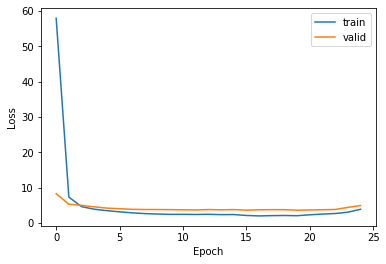

In [13]:
"""
Plotting the training loss:
"""

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["train", "valid"], loc="upper right")
plt.show()

# For inference

In [12]:
print("Loading vision and text encoders...")
vision_encoder = keras.models.load_model("vision_encoder")
text_encoder = keras.models.load_model("text_encoder")
print("Models are loaded.")

Loading vision and text encoders...
Models are loaded.


In [211]:
fine_labels = [
'apple', # id 0
'aquarium_fish',
'baby',
'bear',
'beaver',
'bed',
'bee',
'beetle',
'bicycle',
'bottle',
'bowl',
'boy',
'bridge',
'bus',
'butterfly',
'camel',
'can',
'castle',
'caterpillar',
'cattle',
'chair',
'chimpanzee',
'clock',
'cloud',
'cockroach',
'couch',
'crab',
'crocodile',
'cup',
'dinosaur',
'dolphin',
'elephant',
'flatfish',
'forest',
'fox',
'girl',
'hamster',
'house',
'kangaroo',
'computer_keyboard',
'lamp',
'lawn_mower',
'leopard',
'lion',
'lizard',
'lobster',
'man',
'maple_tree',
'motorcycle',
'mountain',
'mouse',
'mushroom',
'oak_tree',
'orange',
'orchid',
'otter',
'palm_tree',
'pear',
'pickup_truck',
'pine_tree',
'plain',
'plate',
'poppy',
'porcupine',
'possum',
'rabbit',
'raccoon',
'ray',
'road',
'rocket',
'rose',
'sea',
'seal',
'shark',
'shrew',
'skunk',
'skyscraper',
'snail',
'snake',
'spider',
'squirrel',
'streetcar',
'sunflower',
'sweet_pepper',
'table',
'tank',
'telephone',
'television',
'tiger',
'tractor',
'train',
'trout',
'tulip',
'turtle',
'wardrobe',
'whale',
'willow_tree',
'wolf',
'woman',
'worm',
]

coarse_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



my_labels = ['rocket', 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'woman', 'astronaut', 'man', 'doctor']

# Create the text embedding based on the trained text encoder

In [212]:
labels = my_labels

text_descriptions = [f"This is a picture of a {label}" for label in labels]

print(f"Generating embeddings for {len(text_descriptions)} labels...")
text_embeddings = text_encoder.predict(tf.convert_to_tensor(text_descriptions))
#normalize the text embedding
text_embeddings = tf.math.l2_normalize(text_embeddings, axis=1)

print(f"Image embeddings shape: {text_embeddings.shape}.")

Generating embeddings for 15 labels...
Image embeddings shape: (15, 256).


# Create the image embedding

In [213]:
test_image_path = r"C:\Users\blain\Downloads\rocket.jpg"

image_array = tf.image.decode_jpeg(tf.io.read_file(test_image_path), channels=3)
image_array = tf.image.resize(image_array, (299, 299))

image_tensor = tf.convert_to_tensor(image_array)

#reshape because the first dimension is batch size
image_tensor = image_tensor[None,:,:,:]

image_embeddings = vision_encoder(image_tensor)

#image_embeddings /= tf.math.l2_normalize(image_embeddings, axis=1)

print(f"Image embeddings shape: {image_embeddings.shape}.")

Image embeddings shape: (1, 256).


In [214]:
dot_similarity = tf.matmul(100 * text_embeddings, image_embeddings, transpose_b=True)

true_probs = tf.keras.activations.softmax(dot_similarity, axis=0)


results = tf.math.top_k(tf.transpose(dot_similarity), 5).indices.numpy()[0]
probs = tf.math.top_k(tf.transpose(true_probs), 5).values.numpy()[0]

#find the most likely labels
labels = np.array(labels)
top_labels = labels[list(results)]

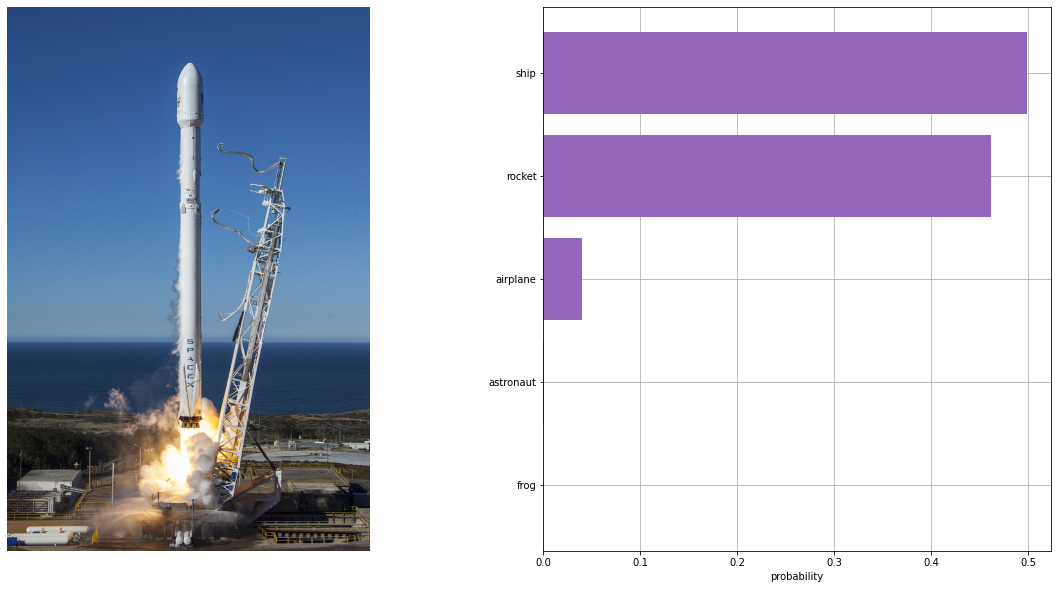

In [215]:
from PIL import Image
image = Image.open(test_image_path).convert("RGB")

#set the image size
plt.figure(figsize=(20, 10))


#show the image
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.axis("off")

#show the probabilities
plt.subplot(1, 2, 2)
for i in range(len(probs)):
    y = np.arange(probs.shape[-1])
    plt.grid()
    plt.barh(y, probs)
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in results])
    plt.xlabel("probability")

plt.show()